In [1]:
# Librerías

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Lectura de TODA la base datos
dfs = pd.read_excel("data/accidentes_Bogota.xlsx", sheet_name=None)

### Descripción de la base de datos:

En el archivo de excel hay 5 hojas: 

- **SINIESTROS:** Información de los Sinietros viales entre 2015 y 2020
- **ACTOR_VIAL:** 
- **VEHICULOS:** 
- **HIPOTESIS:** 
- **DICCIONARIO:** 

In [3]:
dfs["DICCIONARIO"][dfs["DICCIONARIO"]["HOJA"] == "SINIESTROS"]

,HOJA,CAMPO,CODIGO,DESCRIPCION
0,SINIESTROS,GRAVEDAD,1,Con Muertos
1,SINIESTROS,GRAVEDAD,2,Con Heridos
2,SINIESTROS,GRAVEDAD,3,Solo Daños
3,SINIESTROS,CLASE,7,Autolesion
4,SINIESTROS,CLASE,1,Choque
5,SINIESTROS,CLASE,2,Atropello
6,SINIESTROS,CLASE,4,Caida de ocupante
7,SINIESTROS,CLASE,3,Volcamiento
8,SINIESTROS,CLASE,6,Otro
9,SINIESTROS,CLASE,5,Incendio


#### Base de datos de siniestros:

Descripción y análisis de de los siniestros

Columnas relevantes:
- CODIGO_ACCIDENTE: 
- FECHA
- HORA
- GRAVEDAD: Severidad del accidente.



In [4]:
# Unificar la base de datos de actores y siniestros

df = pd.merge(dfs["ACTOR_VIAL"], dfs["SINIESTROS"], on="CODIGO_ACCIDENTE", how="left", suffixes=('', '_y'))
df.drop(columns=["FECHA_y"], inplace=True)

# Añadir también los vehículos 

df = pd.merge(df, dfs["VEHICULOS"], on="VEHICULO", how="left", suffixes=('', '_y'))
df.drop(columns=["CODIGO_ACCIDENTE_y","FECHA_y",], inplace=True)
df.rename(columns={"CLASE_y" : "MODO"}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422416 entries, 0 to 422415
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CODIGO_ACCIDENTE    422416 non-null  int64  
 1   CODIGO_ACCIDENTADO  422416 non-null  int64  
 2   FECHA               422416 non-null  object 
 3   CONDICION           422416 non-null  object 
 4   ESTADO              422416 non-null  object 
 5   EDAD                422416 non-null  object 
 6   SEXO                422416 non-null  object 
 7   VEHICULO            398969 non-null  object 
 8   HORA                422416 non-null  object 
 9   GRAVEDAD            422416 non-null  int64  
 10  CLASE               422416 non-null  int64  
 11  CHOQUE              363809 non-null  float64
 12  OBJETO_FIJO         10551 non-null   float64
 13  DIRECCION           422416 non-null  object 
 14  CODIGO_LOCALIDAD    422416 non-null  int64  
 15  DISENO_LUGAR        422416 non-nul

#### Depuración y transformación de los datos:

En general se realizan los siguientes cambios:

-   Transformar fechas datetime
- Añadir las columnas de mes y día de la semana

In [6]:
# to datetime
df["FECHA_DT"] = pd.to_datetime(df["HORA"]+" "+df["FECHA"])

# Añadir mes
df["MES"] = df["FECHA_DT"].dt.month_name(locale="Spanish")

# Día de la semana
df["DIA_SEMANA"] = df["FECHA_DT"].dt.day_name(locale="Spanish")

# Hora de Día
df["HORA_DIA"] = df["FECHA_DT"].dt.hour

#### Visualización de la temporalidad de los accidentes

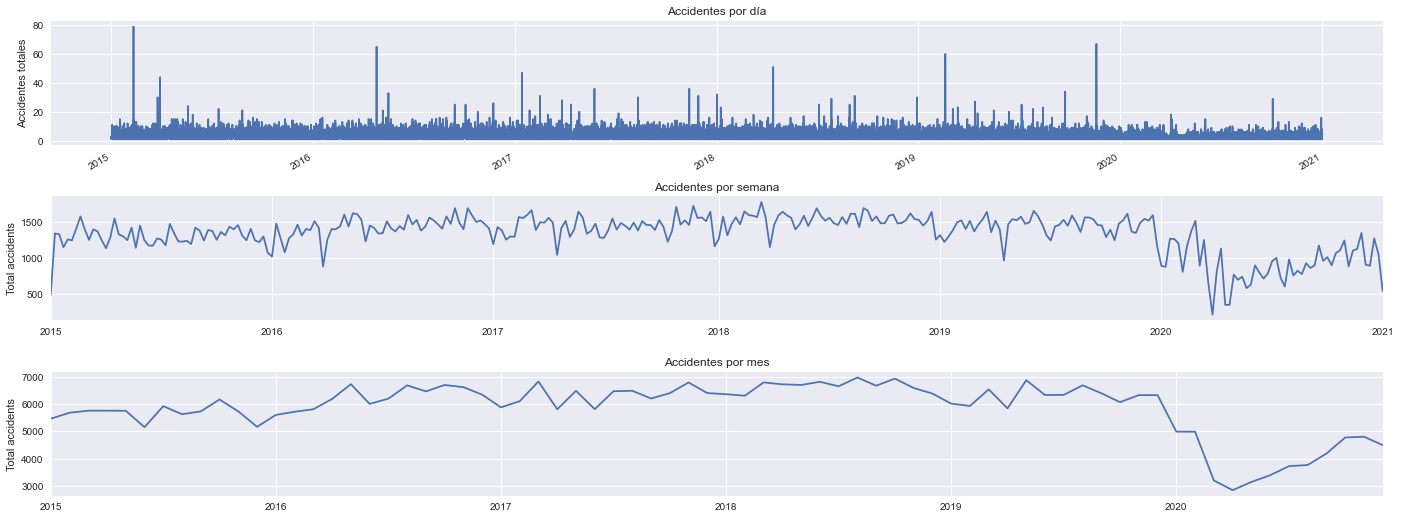

In [7]:
def accidentes_mes():
    monthly_accidents = df["FECHA_DT"].value_counts().to_period("M")
    monthly_accidents = monthly_accidents.groupby(monthly_accidents.index).sum()
    return monthly_accidents


plt.style.use('seaborn') #Seaborn style
plt.rcParams['figure.figsize'] = [20, 9]

fig, axes = plt.subplots(nrows= 3, ncols=1) # creating a figure and axes
fig.tight_layout(pad=4.0) # Specific spacing between subplots

# Create axes using pd.plt()
#its easier to format and style the plot this way, since the data is already in pandas envi.

#creating the axes 0 (Accidents per day plot):
df["FECHA_DT"].value_counts().sort_index(ascending=True).plot(
    title = 'Accidentes por día',
    ylabel='Accidentes totales',
    ax=axes[0]
)
#creating the axes 1 (Accidents per week plot):
df["FECHA_DT"].value_counts().to_period("W").groupby(level=0).sum().plot(
    title = 'Accidentes por semana',
    ylabel='Total accidents',
    ax=axes[1]
)
#creating the axes 2 (Accidents per month plot):
accidentes_mes().to_timestamp().plot(
    title = 'Accidentes por mes',
    ylabel='Total accidents',
    ax=axes[2]);

#### Variables relevantes vs severidad

##### Edad:

<AxesSubplot:xlabel='ESTADO', ylabel='EDAD'>

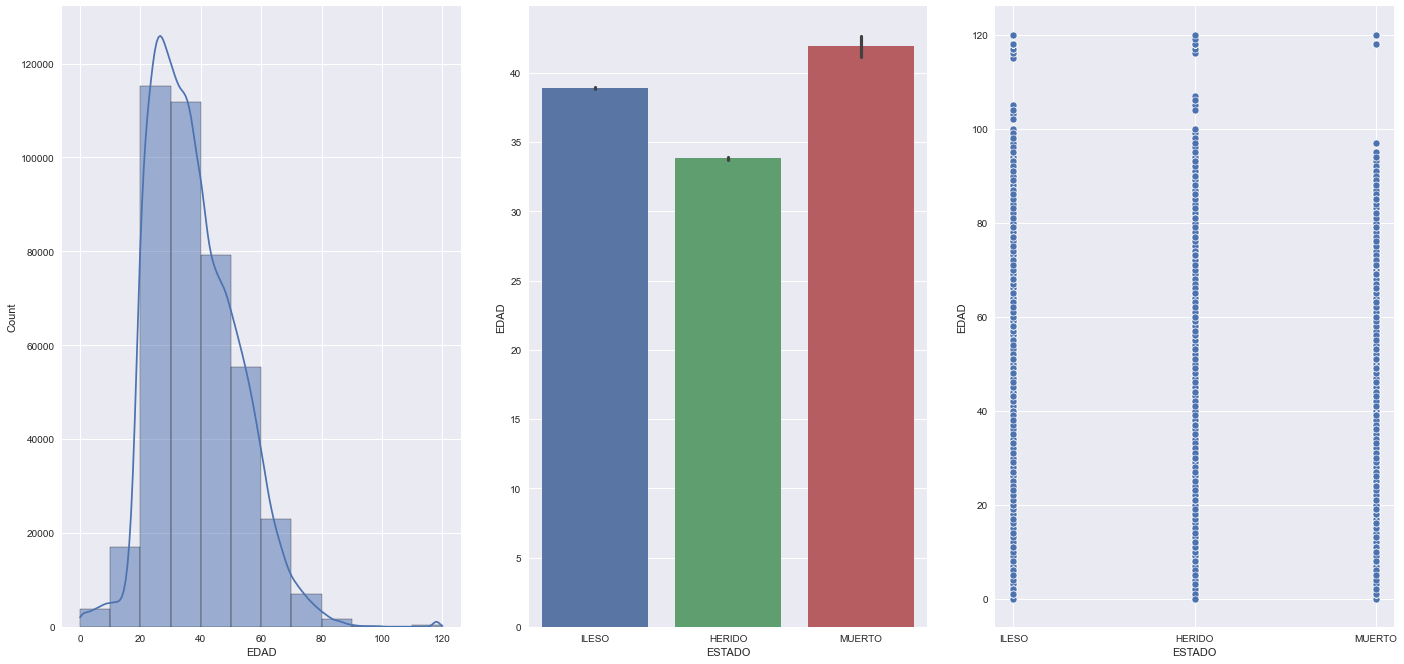

In [8]:
# Estado vs EDAD
plot_df = df[df["EDAD"] != "SIN INFORMACION"]
plt.rcParams['figure.figsize'] = [20, 10]

fig, axes = plt.subplots(nrows= 1, ncols=3) # creating a figure and axes


fig.tight_layout(pad=4.0) # Specific spacing between subplots


sns.histplot(data= plot_df, x="EDAD", bins=12, kde=True, ax=axes[0])
sns.barplot(data= plot_df, y="EDAD", x="ESTADO", ax=axes[1])
sns.scatterplot(data= plot_df, y="EDAD", x="ESTADO", ax=axes[2])

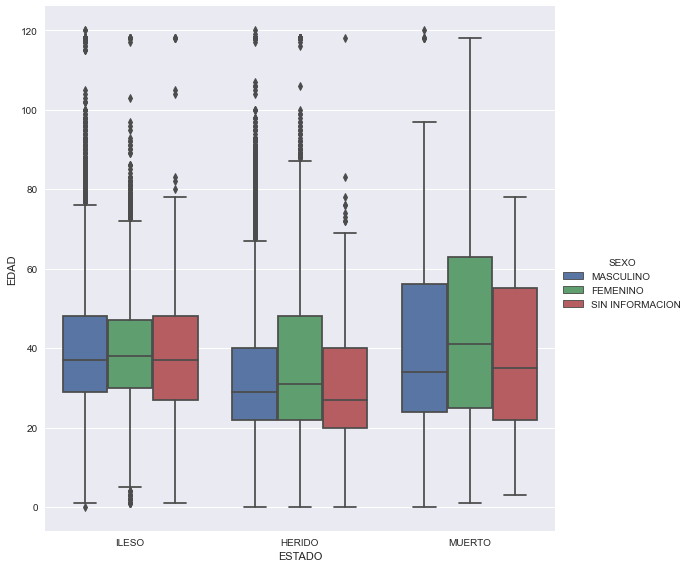

In [9]:
# ESTADO VS EDAD POR SEXO
sns.catplot(data= plot_df, y="EDAD", x="ESTADO", hue="SEXO", kind="box",height=8);

##### Sexo:

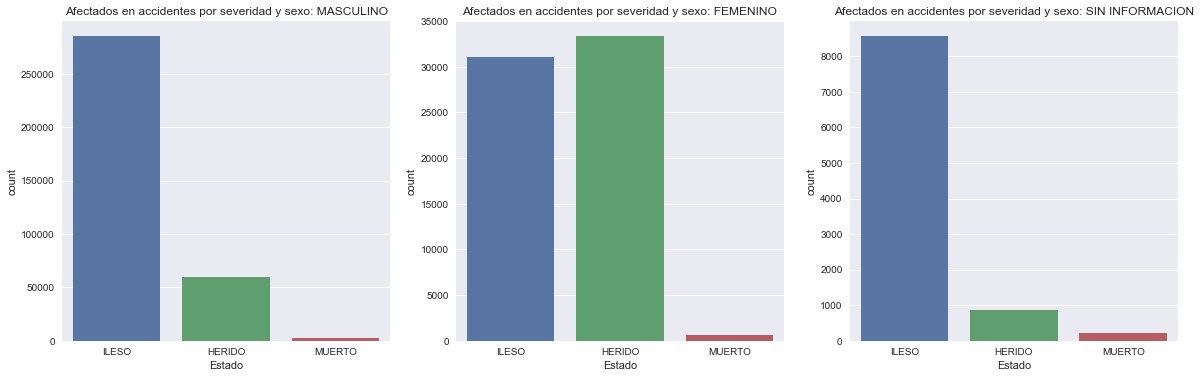

In [10]:
# ESTADO VS SEXO
plt.figure(figsize=(20, 20))

# loop through the scatters list
for i, sexo in enumerate(df["SEXO"].unique()):
    # create a ax iteratively
    ax = plt.subplot(3, 3, i + 1)

    # create a subplot
    sns.countplot(data= df[df["SEXO"] == sexo], x="ESTADO", order=["ILESO", "HERIDO", "MUERTO"], ax=ax)

    # formatting
    ax.set_title("Afectados en accidentes por severidad y sexo: " + sexo,)
    ax.set_xlabel("Estado")

#### Modo:

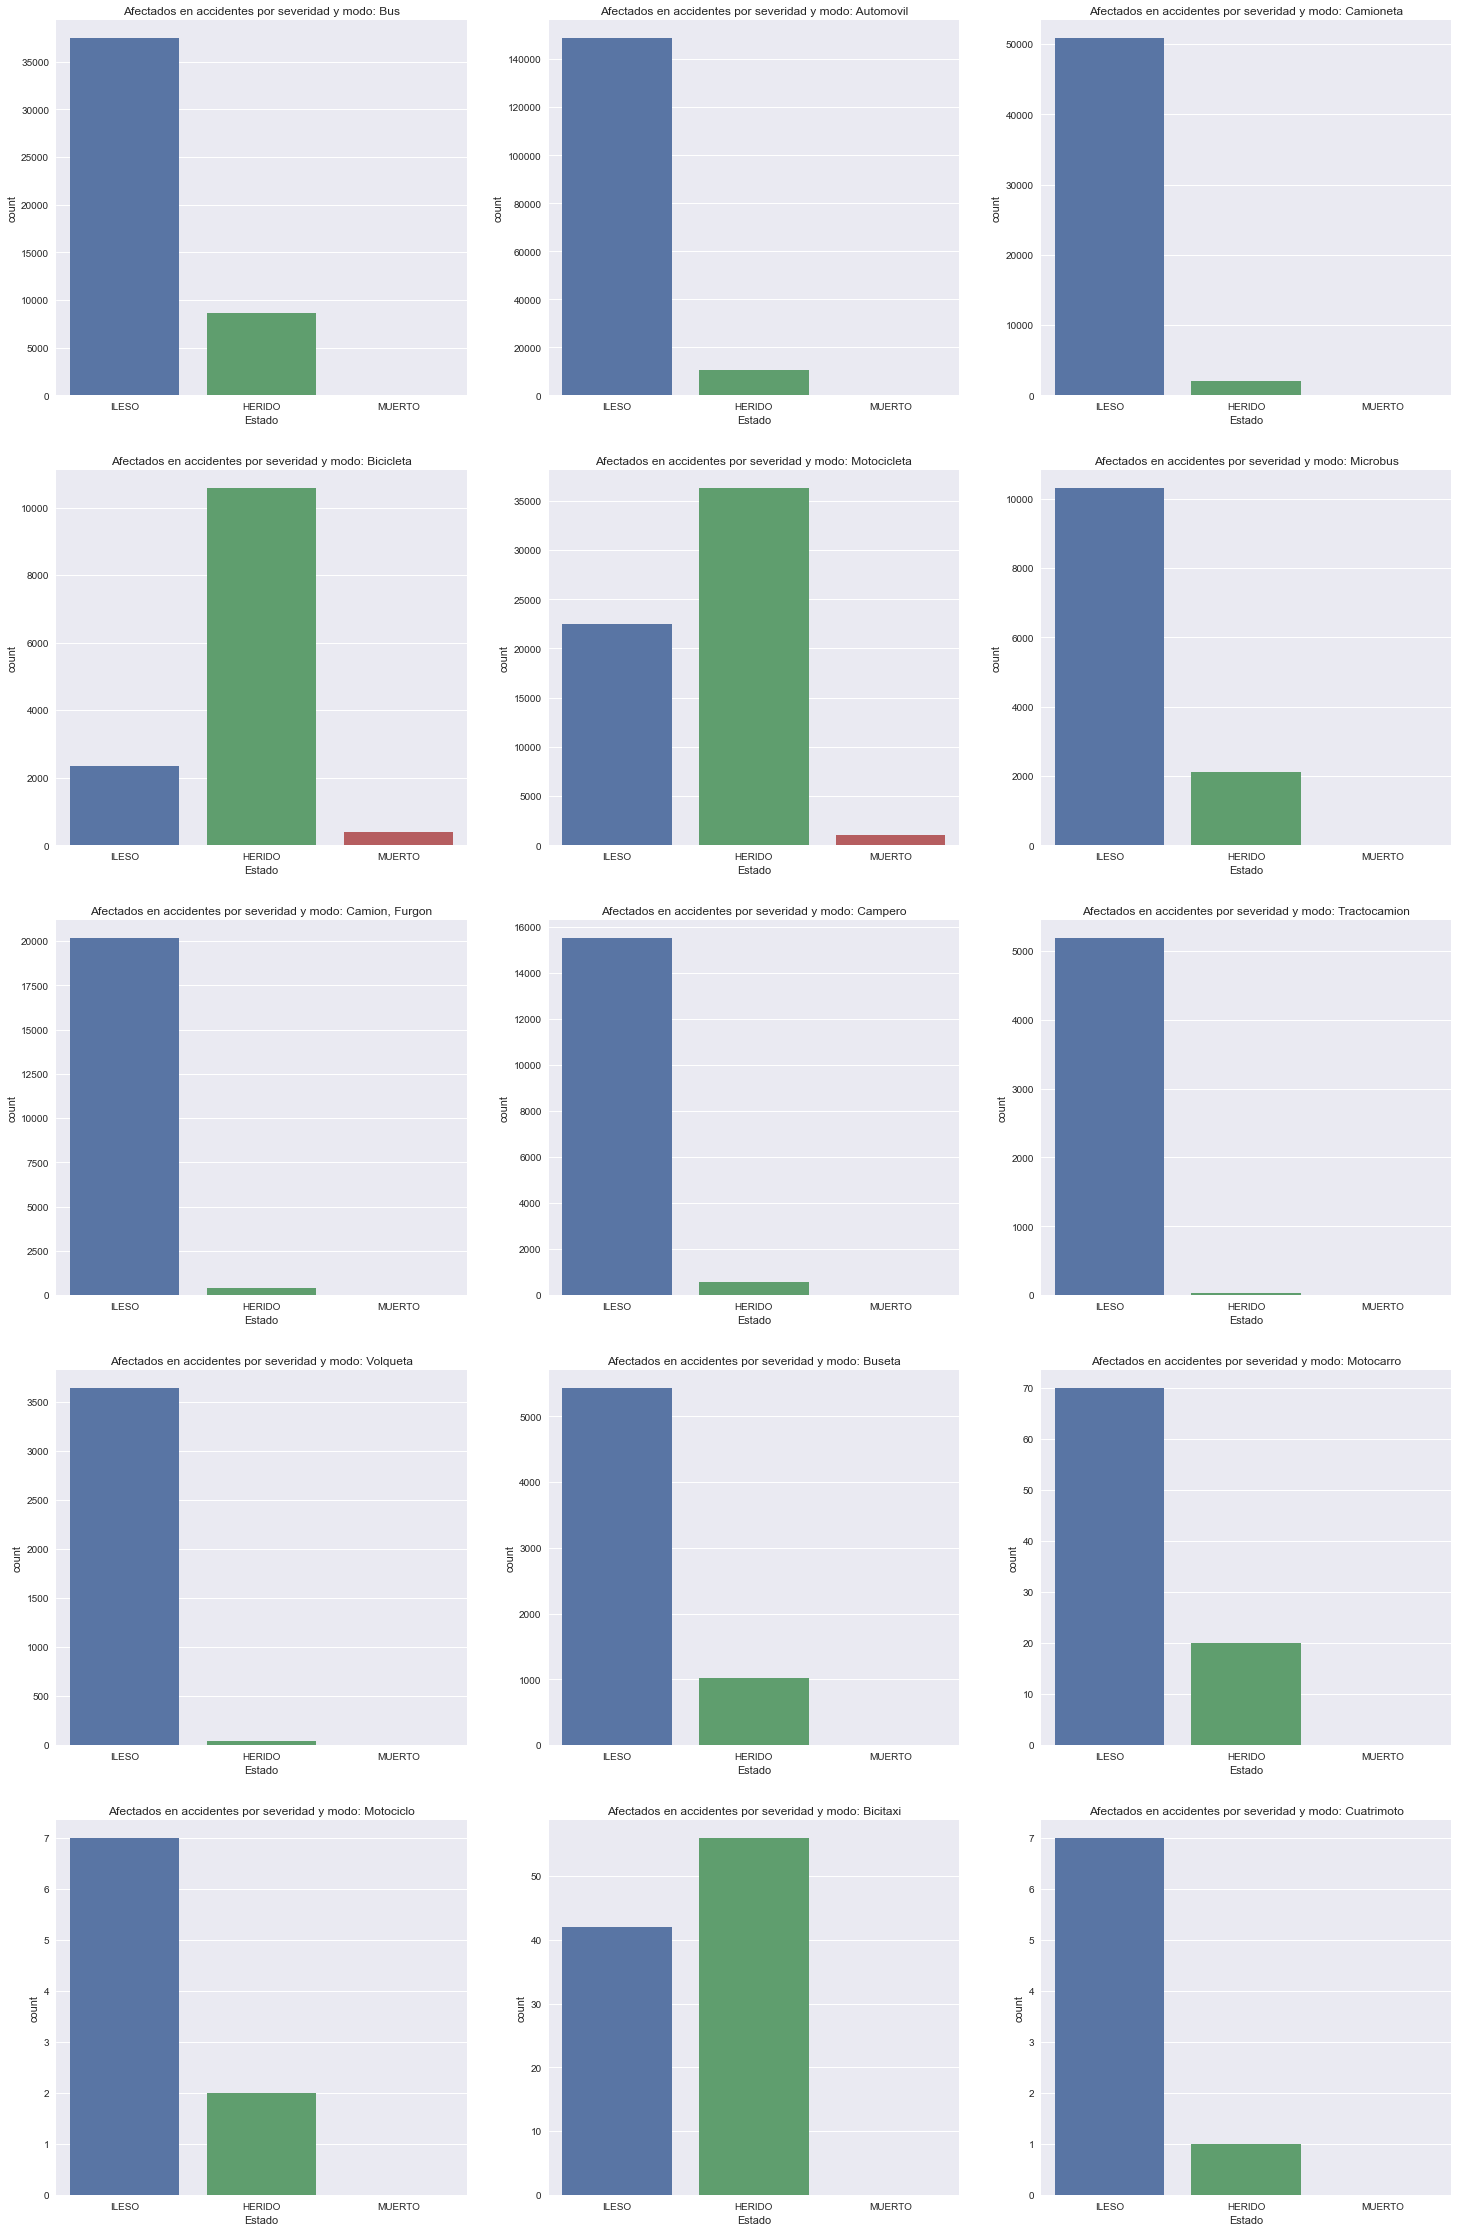

In [11]:
diccinario_modos = dfs["DICCIONARIO"][(dfs["DICCIONARIO"]["HOJA"] == "VEHICULOS") & (dfs["DICCIONARIO"]["CAMPO"] == "CLASE")]


df["MODO_NAME"] = df["MODO"].replace(diccinario_modos["CODIGO"].tolist(), diccinario_modos["DESCRIPCION"].tolist())


# ESTADO VS SEXO
plt.figure(figsize=(25, 40))

# loop through the scatters list
for i, Modo in enumerate(df["MODO_NAME"].dropna().unique()):
    # create a ax iteratively
    ax = plt.subplot(5, 3, i + 1)

    # create a subplot
    sns.countplot(data= df[df["MODO_NAME"] == Modo], x="ESTADO", order=["ILESO", "HERIDO", "MUERTO"], ax=ax)

    # formatting
    ax.set_title("Afectados en accidentes por severidad y modo: " + Modo,)
    ax.set_xlabel("Estado")

##### CONDICIÓN

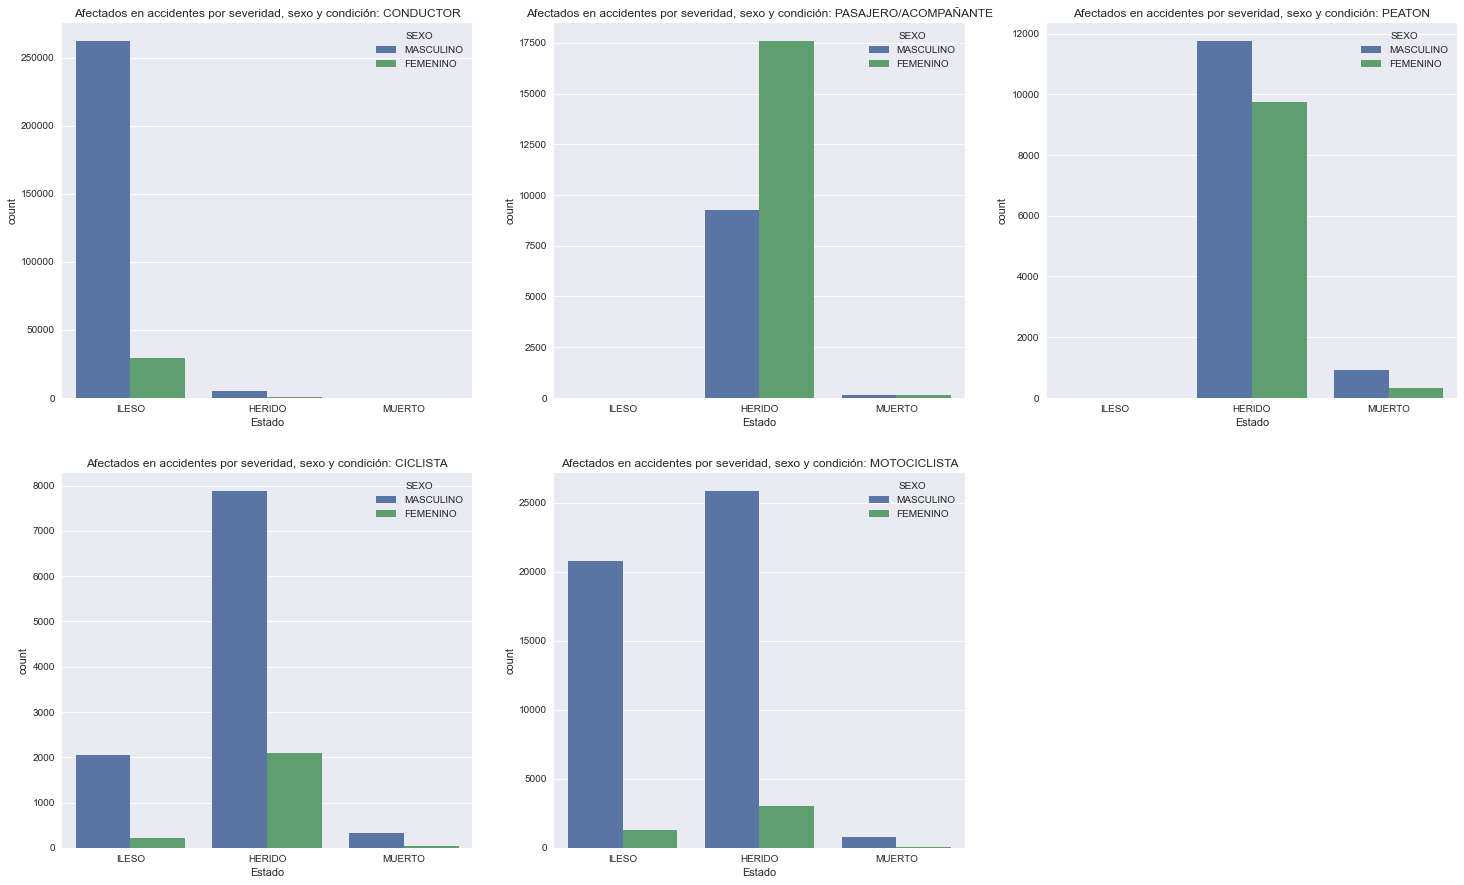

In [12]:

# ESTADO VS CONDICIÓN 
plt.figure(figsize=(25, 40))

# loop through the scatters list
for i, Condicion in enumerate(df["CONDICION"].dropna().unique()):
    # create a ax iteratively
    ax = plt.subplot(5, 3, i + 1)

    # create a subplot
    sns.countplot(data= df[df["CONDICION"] == Condicion], x="ESTADO", hue="SEXO", order=["ILESO", "HERIDO", "MUERTO"], hue_order=["MASCULINO", "FEMENINO"], ax=ax)

    # formatting
    ax.set_title("Afectados en accidentes por severidad, sexo y condición: " + Condicion,)
    ax.set_xlabel("Estado")

##### CLASE:

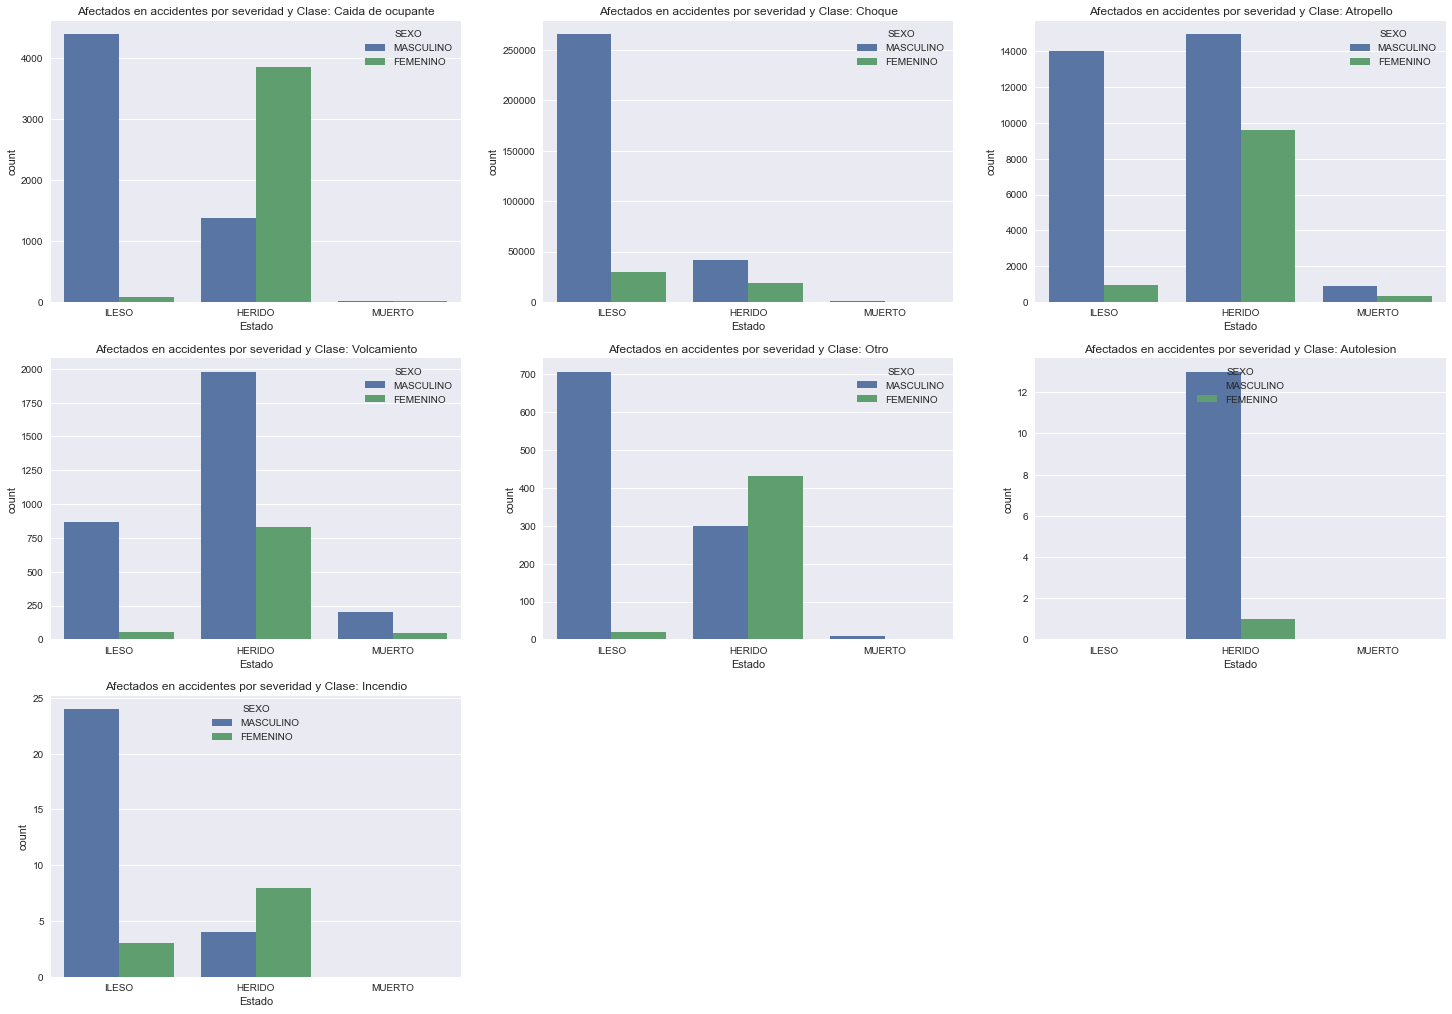

In [13]:
diccinario_clase = dfs["DICCIONARIO"][(dfs["DICCIONARIO"]["HOJA"] == "SINIESTROS") & (dfs["DICCIONARIO"]["CAMPO"] == "CLASE")]


df["CLASE_NAME"] = df["CLASE"].replace(diccinario_clase["CODIGO"].tolist(), diccinario_clase["DESCRIPCION"].tolist())


# ESTADO VS SEXO
plt.figure(figsize=(25, 30))

# loop through the scatters list
for i, Clase in enumerate(df["CLASE_NAME"].dropna().unique()):
    # create a ax iteratively
    ax = plt.subplot(5, 3, i + 1)

    # create a subplot
    sns.countplot(data= df[df["CLASE_NAME"] == Clase], x="ESTADO", hue="SEXO", order=["ILESO", "HERIDO", "MUERTO"], hue_order=["MASCULINO", "FEMENINO"], ax=ax)

    # formatting
    ax.set_title("Afectados en accidentes por severidad y Clase: " + Clase,)
    ax.set_xlabel("Estado")

##### LOCALIDAD

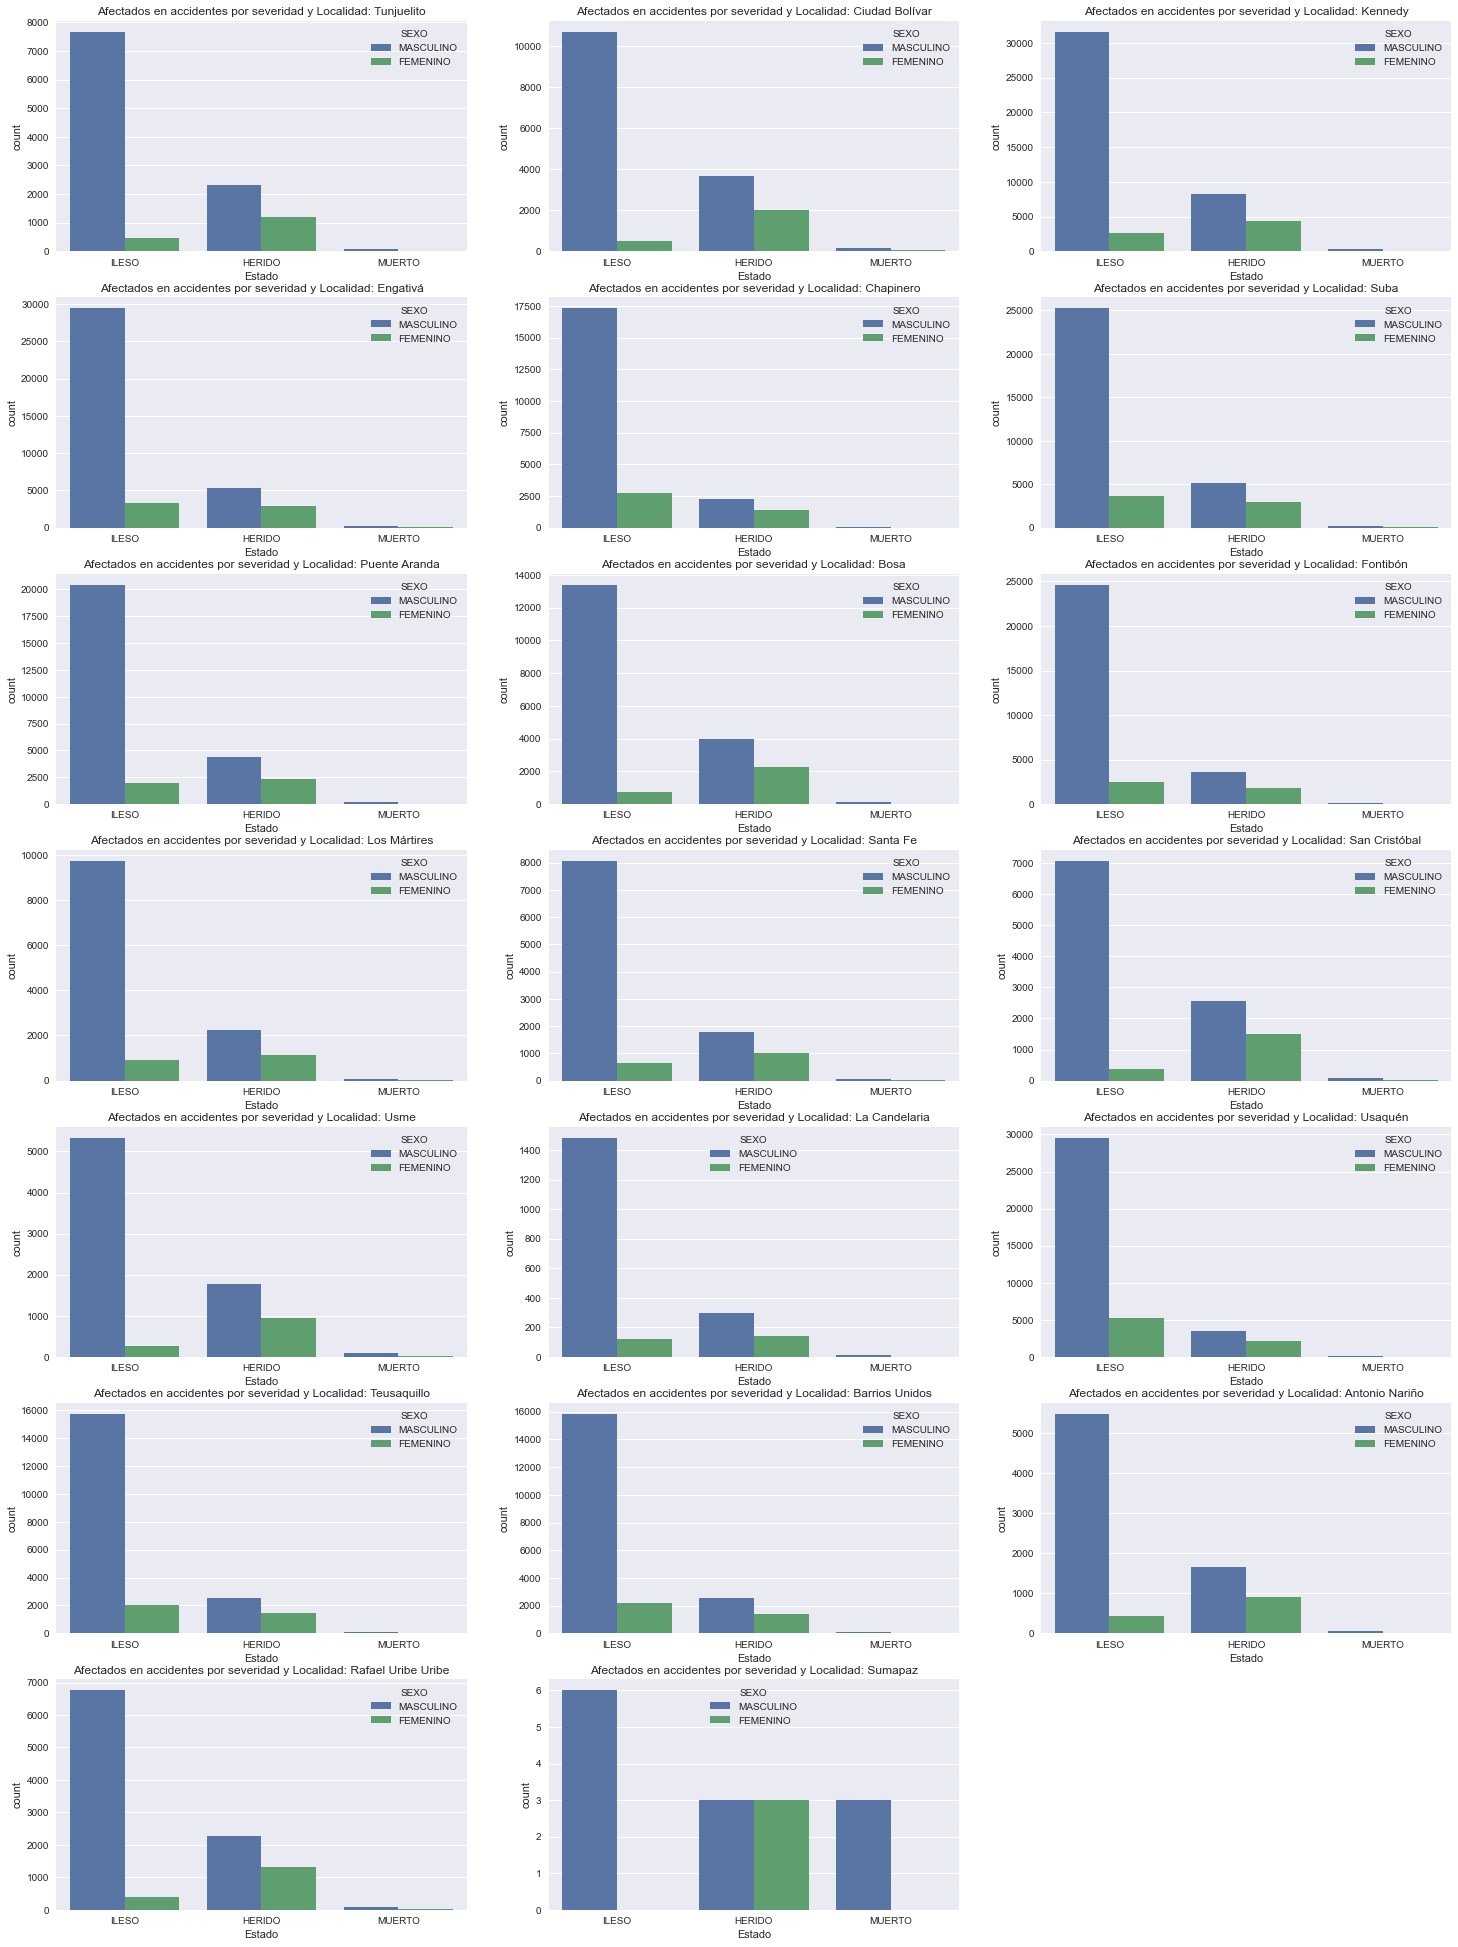

In [14]:
diccinario_localidad = dfs["DICCIONARIO"][(dfs["DICCIONARIO"]["HOJA"] == "SINIESTROS") & (dfs["DICCIONARIO"]["CAMPO"] == "CODIGO_LOCALIDAD")]


df["LOCALIDAD_NAME"] = df["CODIGO_LOCALIDAD"].replace(diccinario_localidad["CODIGO"].tolist(), diccinario_localidad["DESCRIPCION"].tolist())


# ESTADO VS SEXO
plt.figure(figsize=(25, 50))

# loop through the scatters list
for i, Localidad in enumerate(df["LOCALIDAD_NAME"].dropna().unique()):
    # create a ax iteratively
    ax = plt.subplot(10, 3, i + 1)

    # create a subplot
    sns.countplot(data= df[df["LOCALIDAD_NAME"] == Localidad], x="ESTADO", hue="SEXO", order=["ILESO", "HERIDO", "MUERTO"], hue_order=["MASCULINO", "FEMENINO"], ax=ax)

    # formatting
    ax.set_title("Afectados en accidentes por severidad y Localidad: " + Localidad,)
    ax.set_xlabel("Estado")

#### CROSSTABS

<AxesSubplot:xlabel='MODO_NAME', ylabel='LOCALIDAD_NAME'>

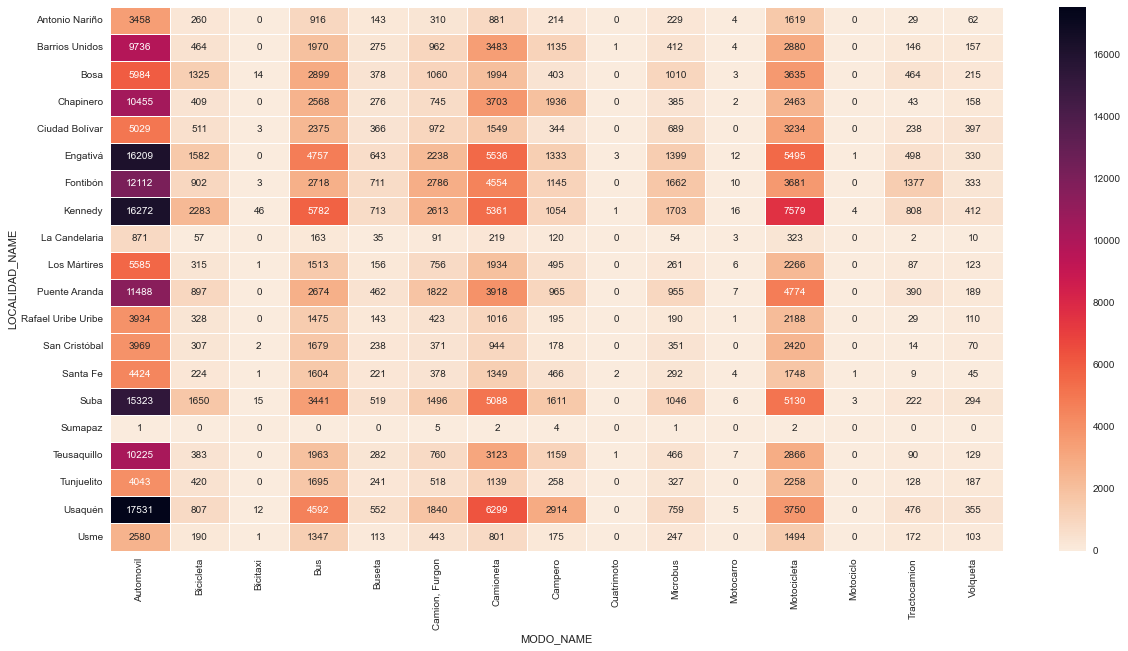

In [15]:
modo_localidad = pd.crosstab(df["LOCALIDAD_NAME"],df["MODO_NAME"])

sns.heatmap(modo_localidad, annot=True,  linewidths=.5, fmt="d", cmap="rocket_r")

<AxesSubplot:xlabel='DIA_SEMANA', ylabel='LOCALIDAD_NAME'>

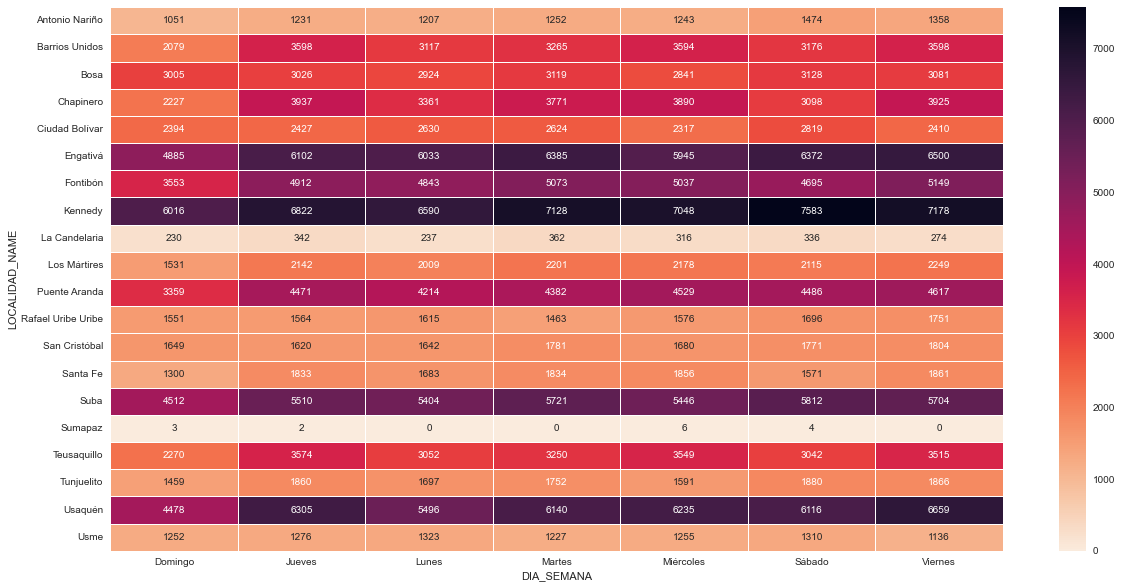

In [16]:
dia_localidad = pd.crosstab(df["LOCALIDAD_NAME"], df["DIA_SEMANA"])

sns.heatmap(dia_localidad, annot=True,  linewidths=.5, fmt="d", cmap="rocket_r")

<AxesSubplot:xlabel='HORA_DIA', ylabel='LOCALIDAD_NAME'>

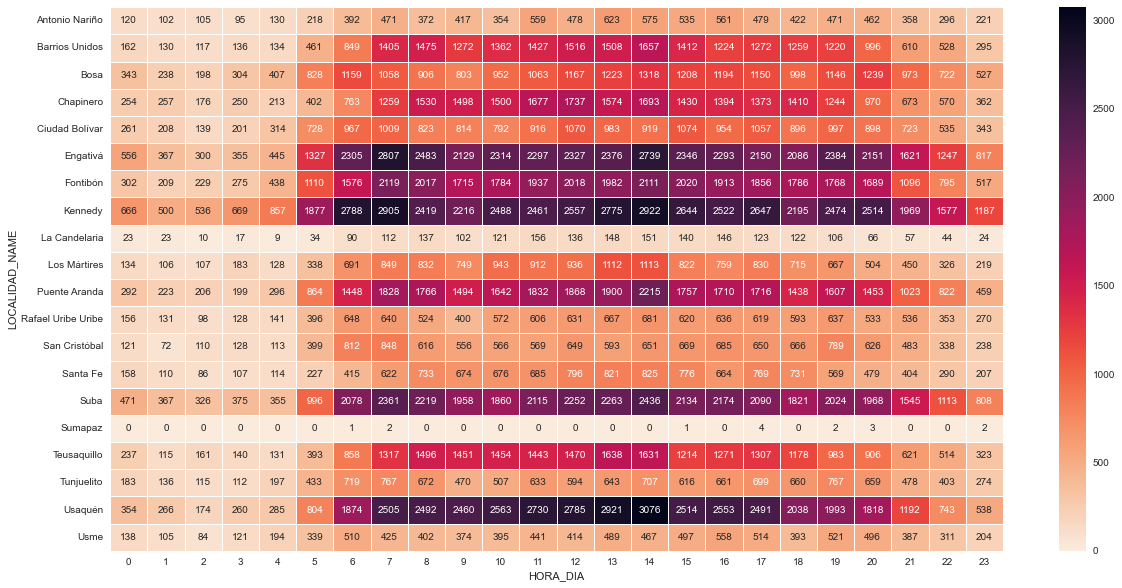

In [17]:
Hora_localidad = pd.crosstab(df["LOCALIDAD_NAME"], df["HORA_DIA"])

sns.heatmap(Hora_localidad, annot=True,  linewidths=.5, fmt="d", cmap="rocket_r")

<AxesSubplot:xlabel='HORA_DIA', ylabel='GRAVEDAD-LOCALIDAD_NAME'>

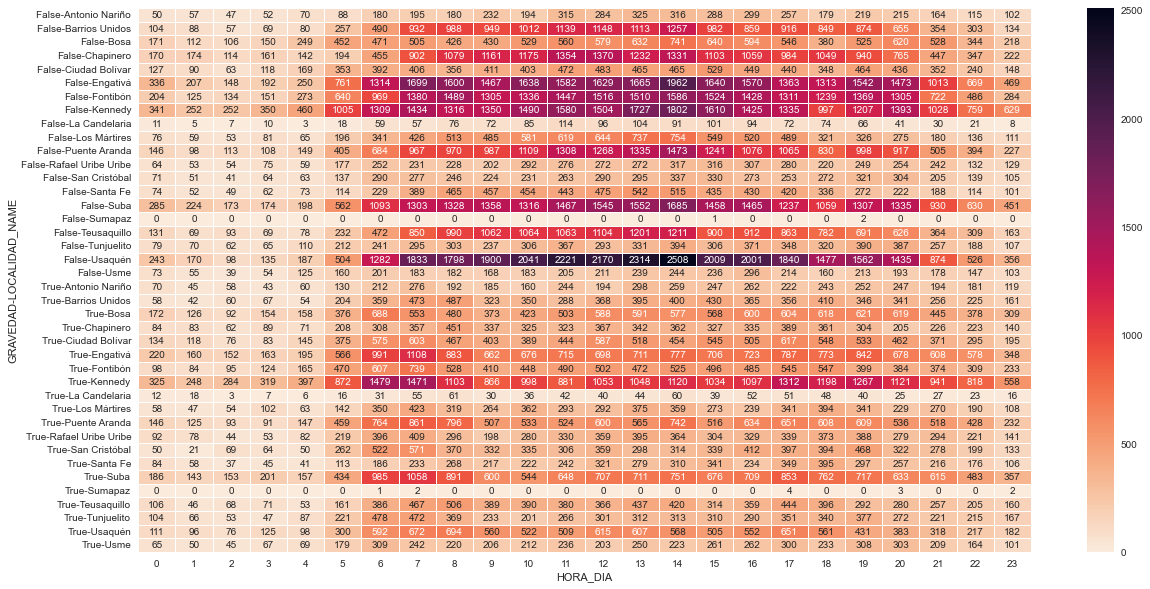

In [25]:
Hora_localidad = pd.crosstab([df["GRAVEDAD"]!=3,df["LOCALIDAD_NAME"]], df["HORA_DIA"])

sns.heatmap(Hora_localidad, annot=True,  linewidths=.5, fmt="d", cmap="rocket_r")

In [ ]:
Heridos_Localidad = pd.